# Point Cloud-to-Graph Cover Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***
Note that for simplicity the notebook is setup to use a simple point cloud. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* random_pointcloud
* annulus
* stanford_bunny
***

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import PointCloudLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_transform_config,
)

Dataset from here: https://github.com/pyt-team/challenge-icml-2024/pull/34/files

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [2]:
dataset_name = "annulus"
dataset_config = load_dataset_config(dataset_name)
loader = PointCloudLoader(dataset_config)


Dataset configuration for annulus:

{'data_domain': 'pointcloud',
 'data_type': 'toy_dataset',
 'data_name': 'annulus',
 'data_dir': 'datasets/pointcloud/toy_dataset/annulus',
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'num_features': 10,
 'num_classes': 3,
 'num_points': 1000,
 'dim': 2}


We can then access to the data through the `load()`method:

In [3]:
dataset = loader.load()
# describe_data(dataset)

CustomDataset() Data(pos=[1000, 2])


## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data. For this example the cover lifting was chosen.

The algorithm initially constructs the Mapper graph from the given point cloud. Each vertex $v$ in the graph is associated with a set of points $\phi(v)$, and two vertices $(u, v)$ are connected if their point sets intersect. Our connectivity test determines whether there is significant evidence for the connectedness of $\phi(u)$ and $\phi(v)$.

We formulate the connectivity test using a recently observed universal property of persistent diagrams[1], which enables us to detect statistically significant homological cycles. The test employs "Weak Universality" and calculates the number of significant relative cycles in $H_1(\phi(u) \cup \phi(v), \phi(u) \setminus \phi(v) \cup \phi(v) \setminus \phi(u))$ as well as the number of significant cycles in $H_1(\phi(u) \cap \phi(v)$. The emergence of new relative cycles confirms the connectivity between $u$ and $v$.

***
[[1]](https://doi.org/10.1038/s41598-023-37842-2) Bobrowski, O., Skraba, P. A universal null-distribution for topological data analysis. Sci Rep 13, 12274 (2023). 
***

In [4]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "pointcloud2graph/cover_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for pointcloud2graph/cover_lifting:

{'transform_type': 'lifting',
 'transform_name': 'CoverLifting',
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcesor`:

Transform parameters are the same, using existing data_dir: /home/patrik/Work/icml2024/challenge-icml-2024/datasets/pointcloud/toy_dataset/annulus/lifting/1967311950

Dataset only contains 1 sample:


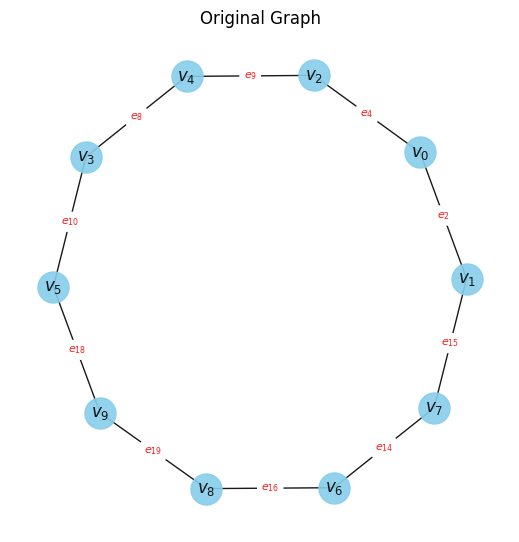

 - Graph with 10 vertices and 20 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [5]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

## Create and Run a Graph NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `up_laplacian_1` and the `down_laplacian_1` so the lifting should make sure to add them to the data.

In [6]:
from torch_geometric.nn.models import GraphSAGE

In [7]:
model = GraphSAGE(
    in_channels=-1,
    hidden_channels=32,
    out_channels=2,
    num_layers=2,
)

In [8]:
y_hat = model(x=lifted_dataset.x, edge_index=lifted_dataset.edge_index)